# Training a convolution neural network to classifiy retina image into left or right handed

Trains a simple convnet on the [DRIVE dataset](http://www.isi.uu.nl/Research/Databases/DRIVE/) [Staal et al, 2004].

J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "[Ridge based vessel segmentation in color images of the retina](http://www.isi.uu.nl/Research/Databases/DRIVE/id=855.html)", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.

In [27]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os, glob
import pandas as pd # load csv
import zipfile # extract zip
from skimage.external import tifffile # read tiff images
from skimage.transform import resize # resize images

# Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1

In [50]:
# unzip data set
with zipfile.ZipFile("../data/DRIVE_retinal_image_data.zip","r") as zip_ref:
    zip_ref.extractall("../data")

In [51]:
# load training images
fns = sorted(glob.glob('../data/DRIVE/training/images/*.tif'))
#print(fns)
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('../data/DRIVE/test/images/*.tif'))
#print(fns)
x_test = np.array([tifffile.imread(fn) for fn in fns])
print(x_train.shape)
print(x_test.shape)

/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


(31, 584, 565, 3)
(9, 584, 565, 3)


In [52]:
# load annotations (the order corresponds to the order of the images)
y_train = pd.read_csv('../data/DRIVE/training/annotation.csv', sep='\t')
y_test = pd.read_csv('../data/DRIVE/test/annotation.csv', sep='\t')
#print(y_train)
#print(y_test)
y_train = y_train.values[:,1]
y_test = y_test.values[:,1]
#print(y_test)
num_classes = 2

y_train.shape

(31,)

Plot some samples from the image data set with titles showing the ground truth labels

In [53]:
def plot_images(images, labels, gt=None):
    # reduce empty dimensions, if any
    images = np.squeeze(images)
    labels = np.squeeze(labels)
    numrows=int(np.ceil(np.sqrt(images.shape[0])))
    print(numrows)
    fig, axes = plt.subplots(nrows=numrows, ncols=numrows, figsize=(8,8), sharex=True, sharey=True)
    fig.tight_layout()
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=plt.get_cmap('gray_r'))
        ax.set_title('{}'.format(labels[i]), fontsize=18)
        ax.axis('off')
        
        # highlight wrong predictions is gt (ground truth) is provided
        if gt is not None:
            if gt[i] != labels[i]:
                ax.imshow(images[i], cmap=plt.get_cmap('viridis'))
                ax.set_title('{}≠{}'.format(labels[i], gt[i]), fontsize=18, fontdict={'color':'red'})


__Preprocessing__

We reduce the image size to 128x128 and convert from `uint8` to `float32` encoding and scale the values in our image to lie between 0 and 1.

In [54]:
img_height = 48
img_width = 48

In [55]:
def preprocess(ims):
    # convert to float32
    ims = ims.astype(np.float32)

    # scale to 0-1 interval
    if ims.max() > 1.0:
        ims /= 255.
    
    # resize to 128x128 
    ims = np.array([resize(im, (img_height,img_width,3), order=3) for im in ims])
    
    print('min: {}, max: {}, shape: {}, type: {}'.format(ims.min(), ims.max(), ims.shape, ims.dtype))
    return ims

x_train = preprocess(x_train)
x_test = preprocess(x_test)


/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


min: 0.0, max: 1.0, shape: (31, 48, 48, 3), type: float64
min: 0.0, max: 1.0, shape: (9, 48, 48, 3), type: float64


4


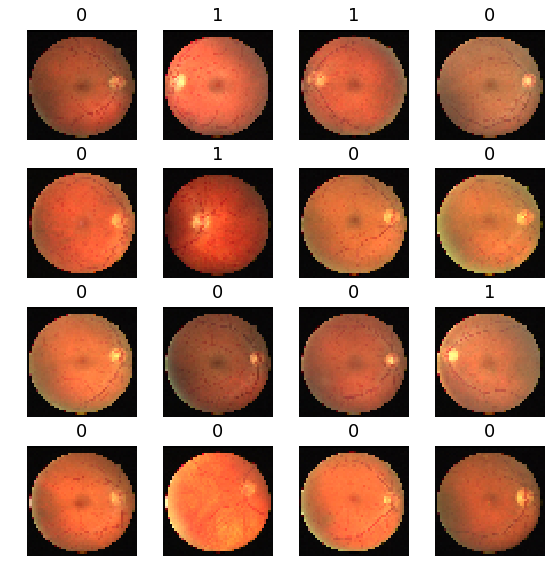

In [56]:
plot_images(x_train[:16], y_train[:16])

__One-hot encoding__

We need to convert the labels using the one-hot encoding scheme

In [57]:
# convert class vectors to binary class matrices
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define a convolutional neural network

In [58]:
def get_cnn():
    
    from keras.models import Model
    from keras import layers
    
    i = layers.Input(shape=(img_height,img_width,3))
    x = layers.BatchNormalization()(i)
    
    ## Convolutional part
    
    # conv layer with 32 3x3 filters and retified linear activation units
    # Note: first layer requires the specification of an input shape
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    # conv layer with 64 3x3 filters and retified linear activation units
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # conv layer with 128 3x3 filters and retified linear activation units
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # conv layer with 256 3x3 filters and retified linear activation units
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    ## Multilayer perceptron (MLP) part

    # first, we need to flatten the output of the conv to obtain a vector
    #x = layers.Flatten()(x)
    x = layers.GlobalAveragePooling2D()(x)
    # add a dense NN layer (= fully connected layer of neurons) with ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # dropout layer
    x = layers.Dropout(0.5)(x)
    # add a dense NN layer (= fully connected layer of neurons) with ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # dropout layer
    x = layers.Dropout(0.5)(x)
    # final layer is equal to the number of classes and uses SoftMax activation 
    o = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=[i], outputs=[o])


__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

In [59]:
model = get_cnn()
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 3)         12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 46, 46, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 128)       0         
__________

# Train the neural network

In [60]:
batch_size = 12
epochs = 200

In [61]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(31, 48, 48, 3)
(31, 2)
(9, 48, 48, 3)
(9, 2)


In [62]:
history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True,
                      verbose=2,
                      validation_data=(x_test, y_test))


Train on 31 samples, validate on 9 samples
Epoch 1/200
 - 0s - loss: 0.7259 - acc: 0.6452 - val_loss: 0.6832 - val_acc: 0.5556
Epoch 2/200
 - 0s - loss: 0.6202 - acc: 0.7742 - val_loss: 0.6703 - val_acc: 0.5556
Epoch 3/200
 - 0s - loss: 0.5054 - acc: 0.8065 - val_loss: 0.6719 - val_acc: 0.5556
Epoch 4/200
 - 0s - loss: 0.4532 - acc: 0.8065 - val_loss: 0.6677 - val_acc: 0.5556
Epoch 5/200
 - 0s - loss: 0.5664 - acc: 0.7742 - val_loss: 0.6594 - val_acc: 0.5556
Epoch 6/200
 - 0s - loss: 0.4100 - acc: 0.8065 - val_loss: 0.6596 - val_acc: 0.5556
Epoch 7/200
 - 0s - loss: 0.4120 - acc: 0.8387 - val_loss: 0.6648 - val_acc: 0.5556
Epoch 8/200
 - 0s - loss: 0.3191 - acc: 0.8387 - val_loss: 0.6396 - val_acc: 0.5556
Epoch 9/200
 - 0s - loss: 0.1994 - acc: 0.8387 - val_loss: 0.5561 - val_acc: 0.5556
Epoch 10/200
 - 0s - loss: 0.1890 - acc: 0.9355 - val_loss: 0.4959 - val_acc: 0.8889
Epoch 11/200
 - 0s - loss: 0.0836 - acc: 0.9677 - val_loss: 0.3886 - val_acc: 1.0000
Epoch 12/200
 - 0s - loss: 0.13

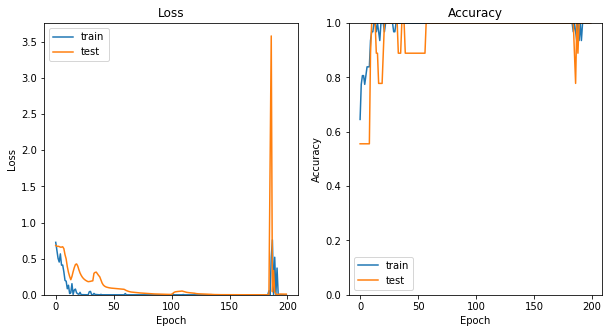

In [63]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax[0].plot(history.history['loss'])
    if validation:
        ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(bottom=0.)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'test'])
    
    # plot history for F score etc.
    ax[1].plot(history.history['acc'])
    if validation:
        ax[1].plot(history.history['val_acc'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylim(bottom=0., top=1.0)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'test'])

plot_history(history, validation=True)

In [64]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 0s 329us/step
Test loss: 0.00926205702126
Test accuracy: 1.0


# Predict unseen examples

In [65]:
num=36
import time
start = time.time()
y_pred = model.predict(x_test[:num], verbose=1, batch_size=12)
end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))

9/9 [==============================] - 0s 7ms/step
Exec time per prediction = 0.002


Predictions are returned as vectors in one-hot encoding. Or rather, they are the activations of the last layer in the NN.

In [66]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 1, 0, 1, 0, 0, 0, 1])

In [67]:
gt = np.argmax(y_test[:num], axis=1) 
gt

array([1, 0, 1, 0, 1, 0, 0, 0, 1])

3


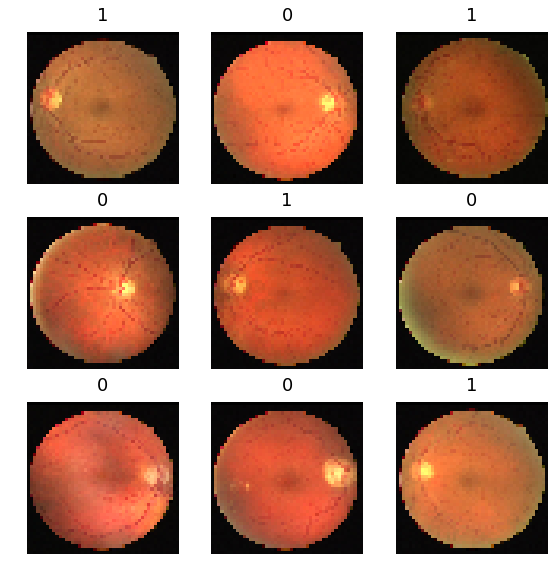

In [68]:
plot_images(x_test[:num], y_pred, gt=gt)

In [26]:
x_test.shape

(9, 48, 48, 3)